In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,\
    precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
inputData = pd.read_csv('input/winequality-white.csv', sep = ";")
inputData.columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality']

# Exploratory Data Analysis

In [3]:
inputData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed_acidity           4898 non-null float64
volatile_acidity        4898 non-null float64
citric_acid             4898 non-null float64
residual_sugar          4898 non-null float64
chlorides               4898 non-null float64
free_sulfur_dioxide     4898 non-null float64
total_sulfur_dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


No null values are in place.

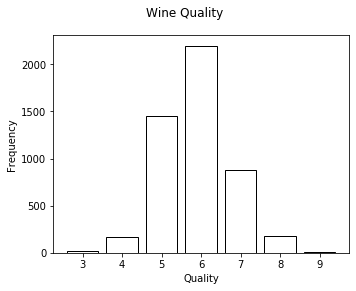

In [4]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("Wine Quality")

ax2 = fig.add_subplot(1,3,2)
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency") 
ww_q = inputData.quality.value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
bar2 = ax2.bar(ww_q[0], ww_q[1], color='white', edgecolor='black', linewidth=1)


There are almost no extremely bad or good quality.

In [5]:
inputData.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


As it can be seen, means and standard deviations are rather different, so, it will make sense to standardize input data by subtracting mean and dividing by standard deviation.

In [6]:
scaler = StandardScaler()
inputDataScaled = scaler.fit_transform(inputData[inputData.columns.drop('quality')])
inputDataScaled = pd.DataFrame(inputDataScaled, columns=inputData.columns.drop('quality'))
inputDataScaled['quality'] = inputData['quality']

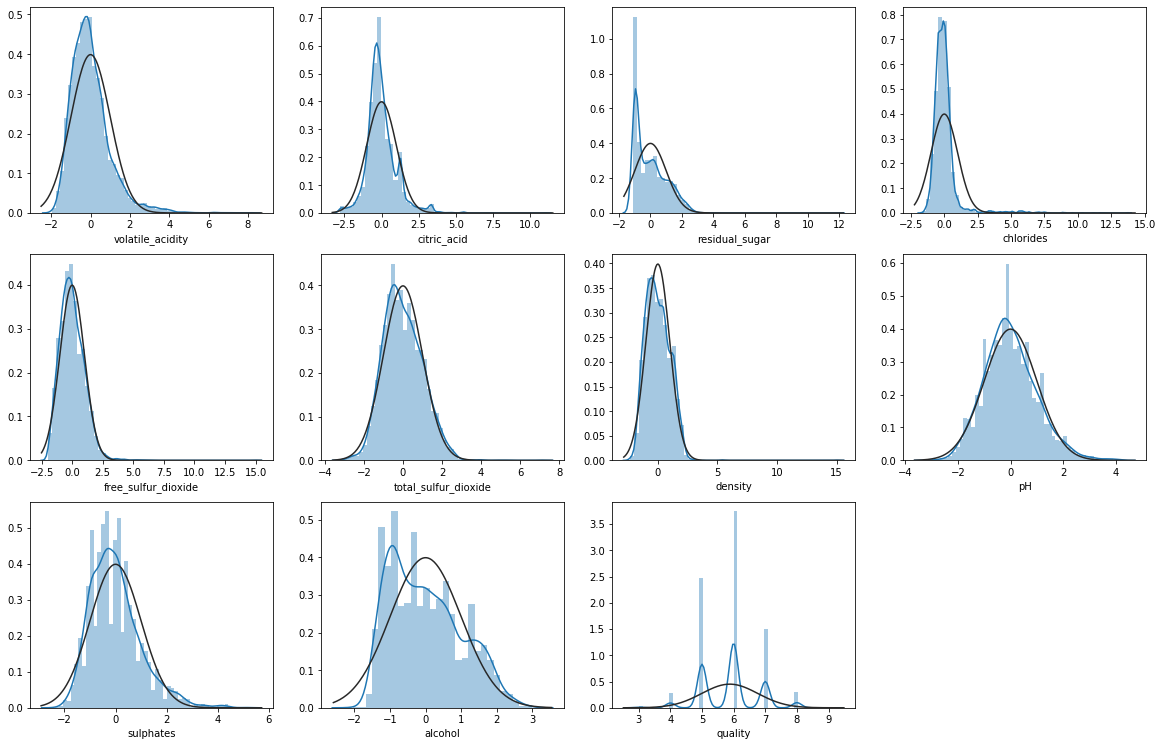

In [7]:
plt.figure(figsize = (20,22))

for i in range(1,12):
    plt.subplot(5,4,i)
    sns.distplot(inputDataScaled[inputDataScaled.columns[i]], fit=norm)

As it can be seen from the above graph, most of independent variables are close to normal distribution, some of them have pronounced skew.

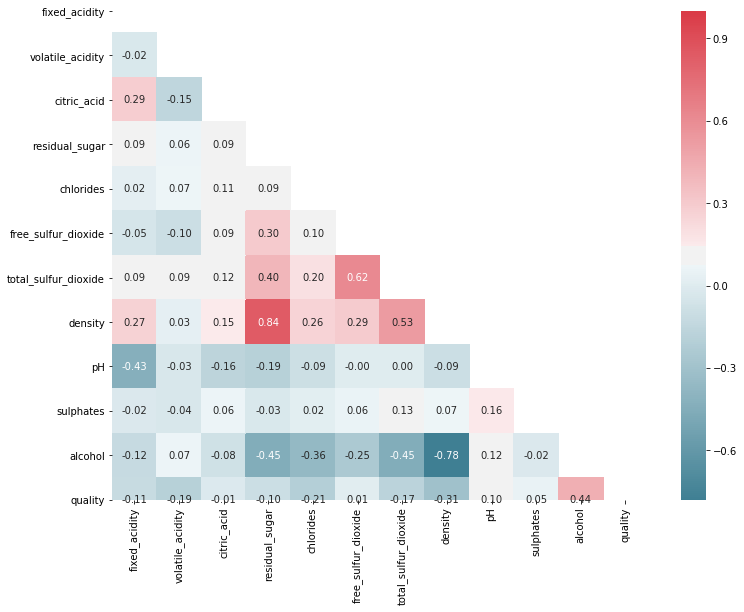

In [8]:
plt.figure(figsize=(12,9))
corr_matrix = inputDataScaled.corr()
dropSelf = np.zeros_like(corr_matrix)
dropSelf[np.triu_indices_from(dropSelf)] = True

sns.heatmap(corr_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)

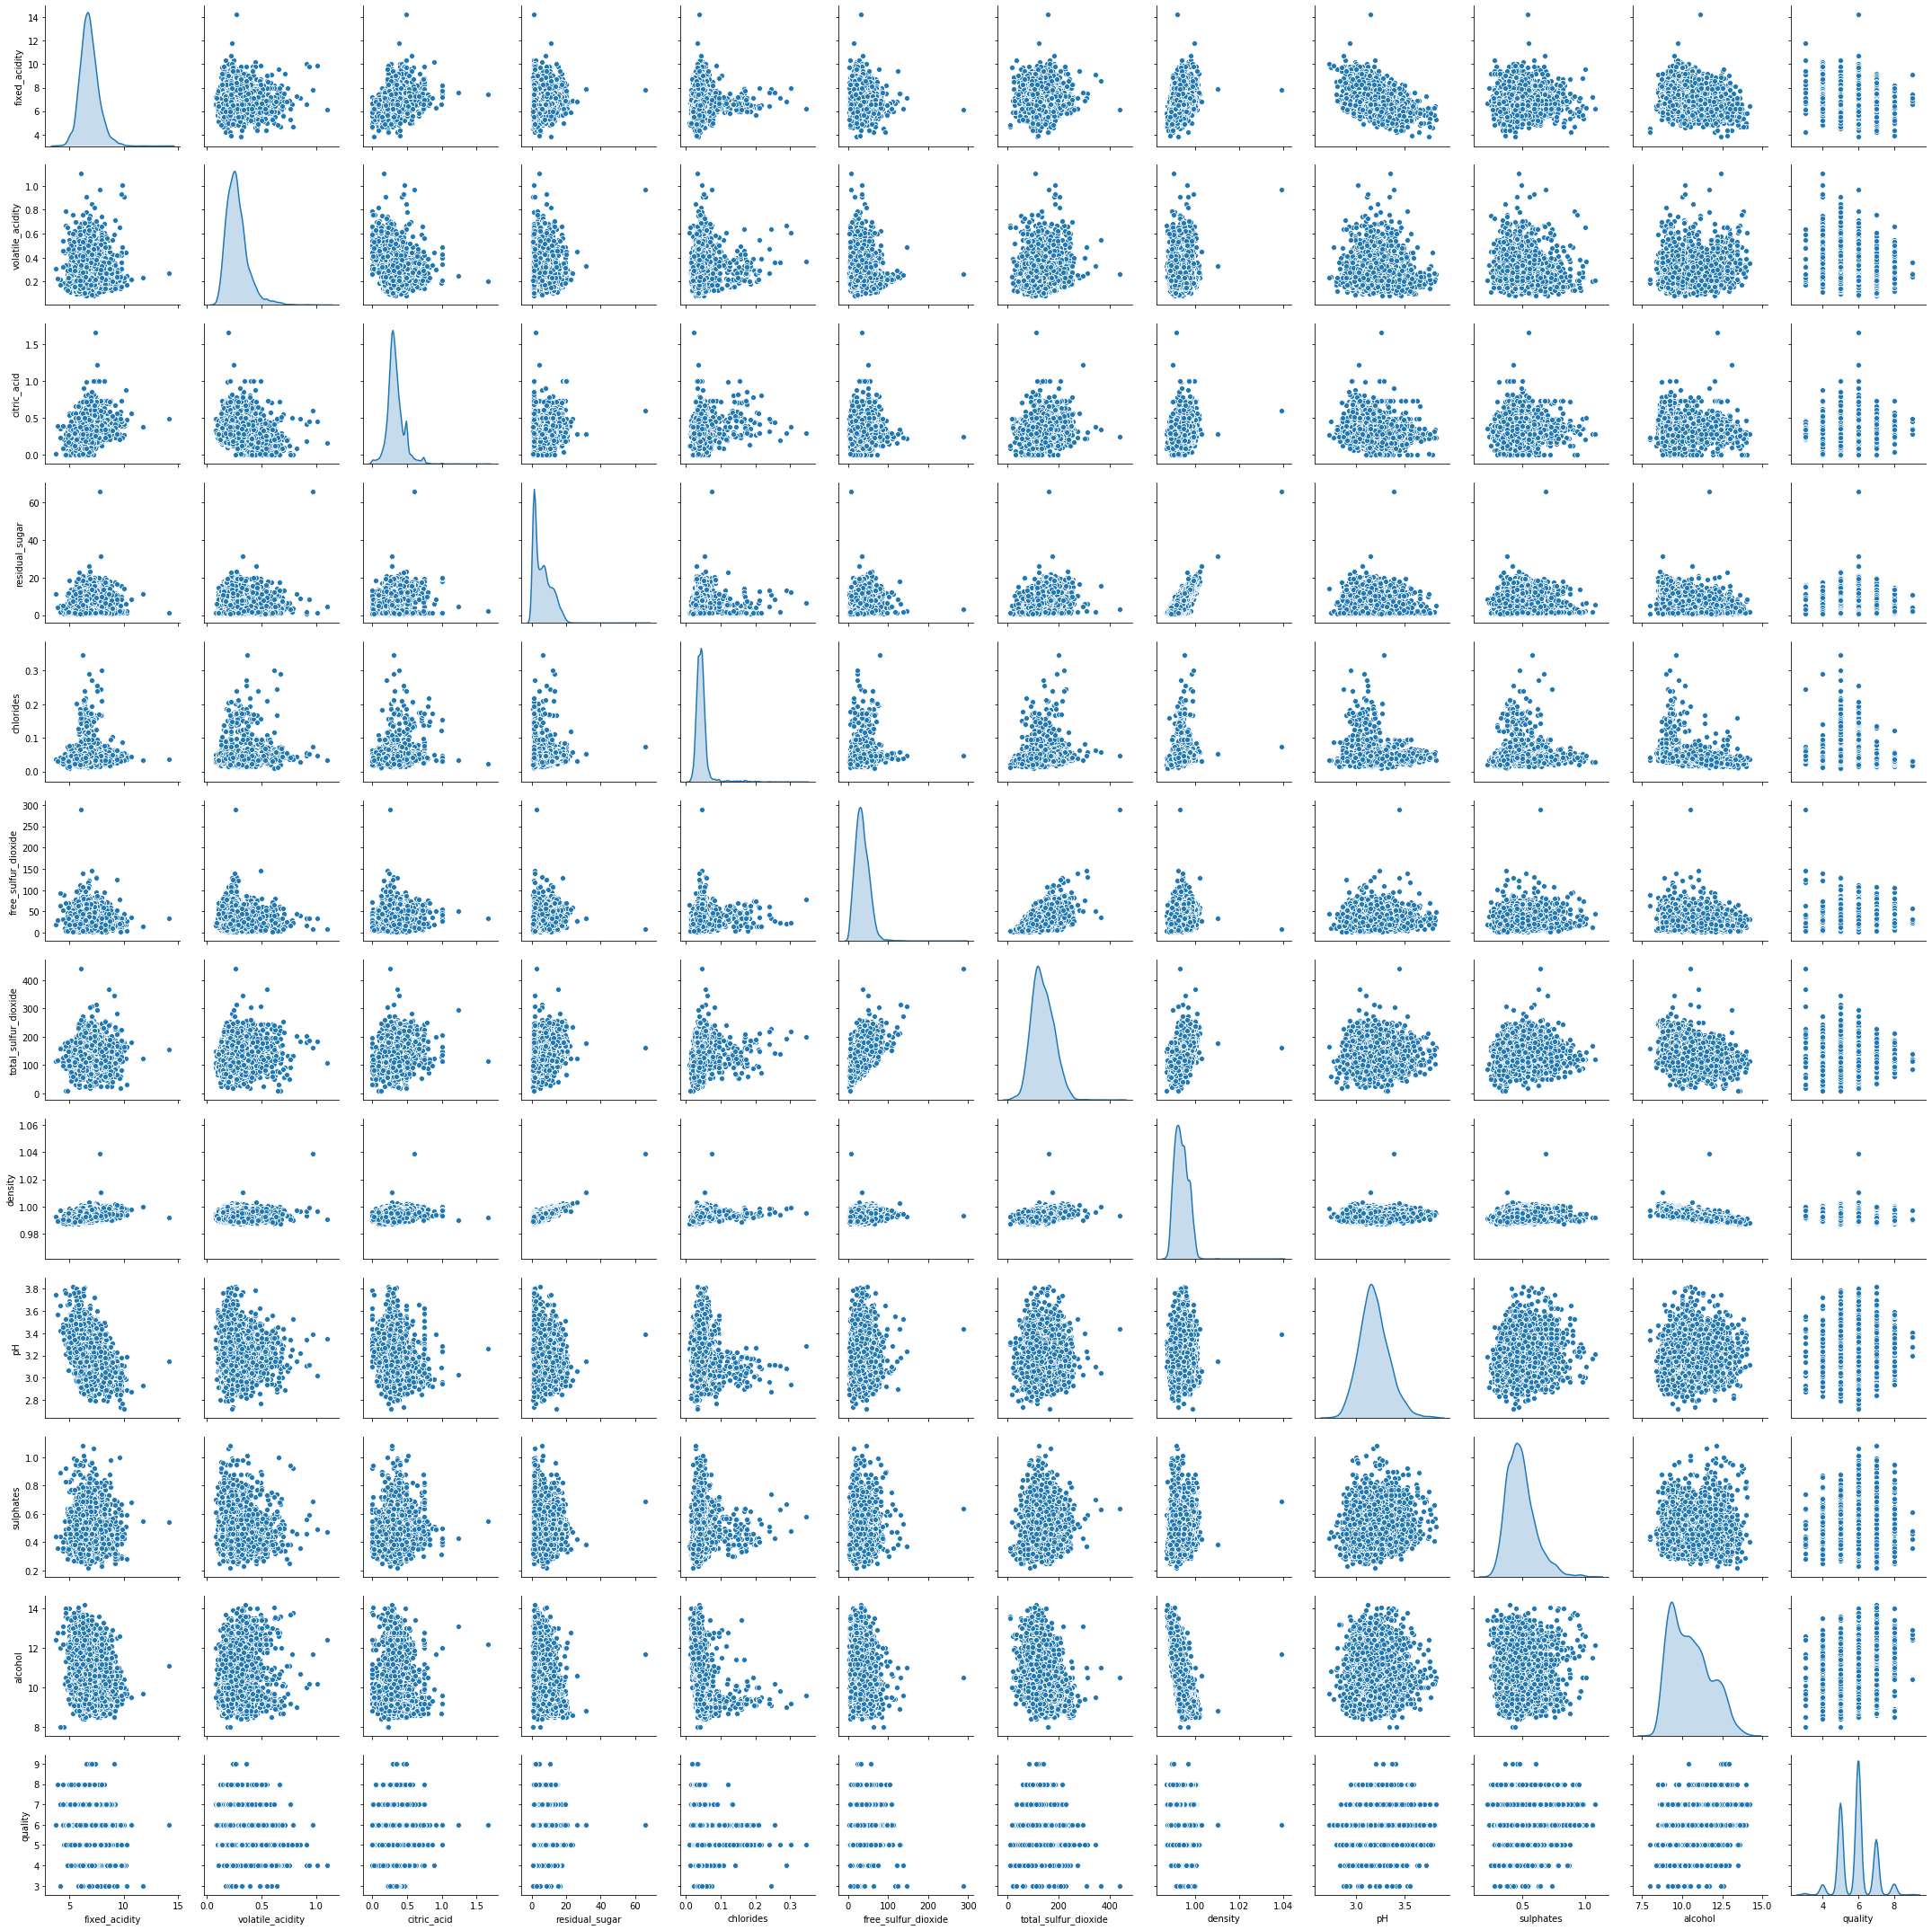

In [9]:
sns.pairplot(inputData,palette="husl",diag_kind="kde")

Total sulfur dioxide has rather high correlation with free sulfur dioxide that is expected given that, by definition, total sulfur dioxide (TSO2) is the portion of SO2 that is free in the wine plus the portion that is bound to other chemicals in the wine such as aldehydes, pigments, or sugars (https://www.extension.iastate.edu/wine/total-sulfur-dioxide-why-it-matters-too).

Density has significant positive correlation with residual sugar and negative with alcohol. In addition, moderate correlation is observed between density and total sulfur dioxide, pH and fixed acidity, alcohol and residual sugar and alcohol and total sulfur dioxide. 

So, we can exclude free sulfur dioxide from the set of explanatory variables and try to exclude different combination of density, residual sugar, pH and fixed acidity.

In [10]:
y, X = dmatrices('quality' + ' ~' + 'fixed_acidity + volatile_acidity + citric_acid + \
                 residual_sugar + chlorides + total_sulfur_dioxide + density + pH + sulphates + alcohol', 
                 data = inputDataScaled, return_type='dataframe')

columns = inputDataScaled.columns.drop(['free_sulfur_dioxide', 'quality'])

for i in range(columns.shape[0]):    
    print(columns[i])
    print(variance_inflation_factor(X.values, i+1))

fixed_acidity
2.691434056168264
volatile_acidity
1.100261210500811
citric_acid
1.1636560137025838
residual_sugar
12.24149280655667
chlorides
1.2357605199236705
total_sulfur_dioxide
1.4512592953290573
density
27.549536921340035
pH
2.1904083223742123
sulphates
1.1384166697689826
alcohol
7.63096806013599


Let's try to remove variable with highest VIF - density.

In [11]:
y, X = dmatrices('quality' + ' ~' + 'fixed_acidity + volatile_acidity + citric_acid + residual_sugar + \
                 chlorides + total_sulfur_dioxide + pH + sulphates + alcohol', 
                 data = inputDataScaled, return_type='dataframe')

columns = inputDataScaled.columns.drop(['free_sulfur_dioxide', 'quality', 'density'])
for i in range(columns.shape[0]):    
    print(columns[i])
    print(variance_inflation_factor(X.values, i+1))

fixed_acidity
1.3226082278088953
volatile_acidity
1.0787607345323227
citric_acid
1.1590730370913416
residual_sugar
1.421955797514115
chlorides
1.2036268673740602
total_sulfur_dioxide
1.4265445117360518
pH
1.3262371384954073
sulphates
1.055494980729531
alcohol
1.6353351169210393


VIF numbers are significantly decreased.

In [12]:
def BoxAndViolinPlot(inpedendent, dependent, data):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    f.suptitle(dependent + ' - ' + inpedendent, fontsize=14)

    sns.boxplot(x=dependent, y=inpedendent, data=data, ax=ax1)
    ax1.set_xlabel(dependent,size = 12,alpha=0.8)
    ax1.set_ylabel(inpedendent, size = 12,alpha=0.8)

    sns.violinplot(x=dependent, y=inpedendent, data=data, split=True, inner='quart', linewidth=1.3,
               ax=ax2)
    ax2.set_xlabel(dependent,size = 12,alpha=0.8)
    ax2.set_ylabel(inpedendent,size = 12,alpha=0.8)
    plt.show()    

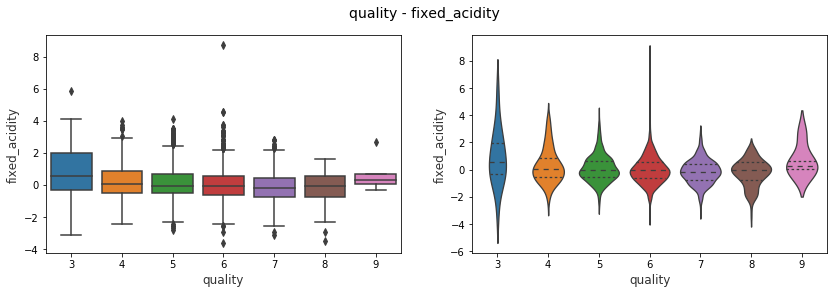

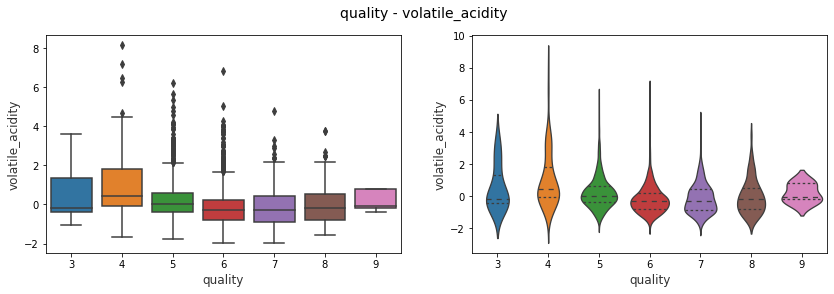

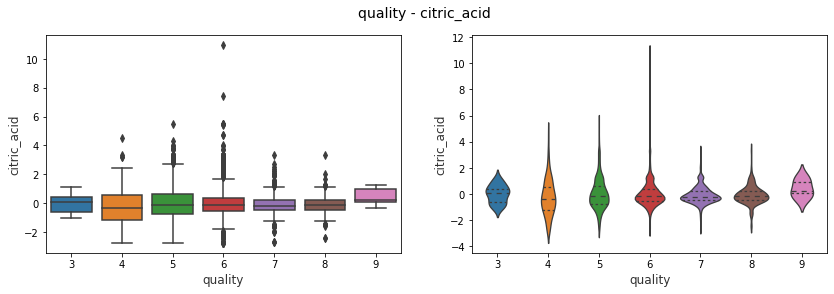

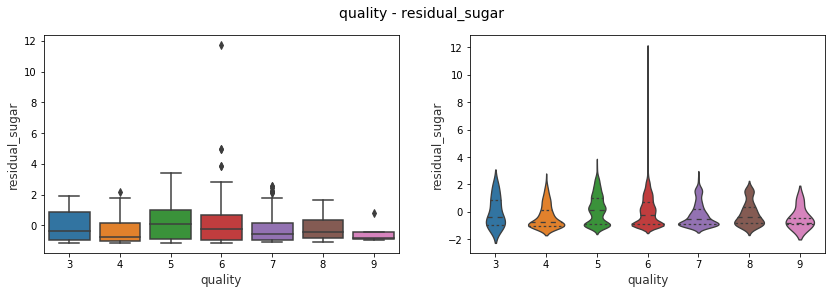

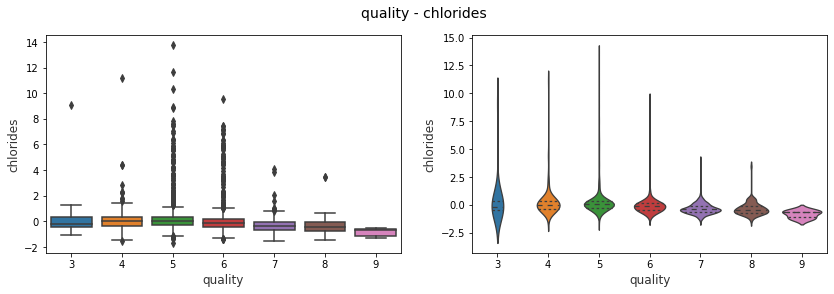

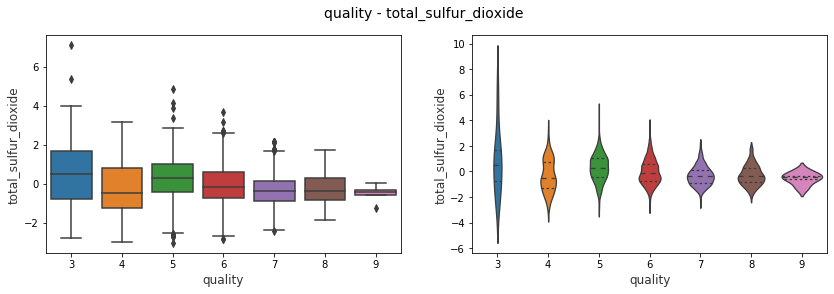

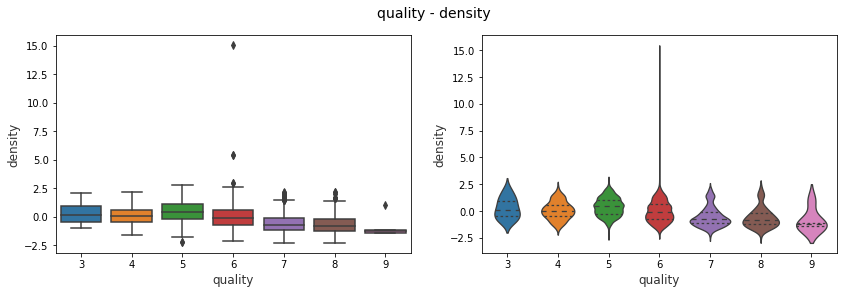

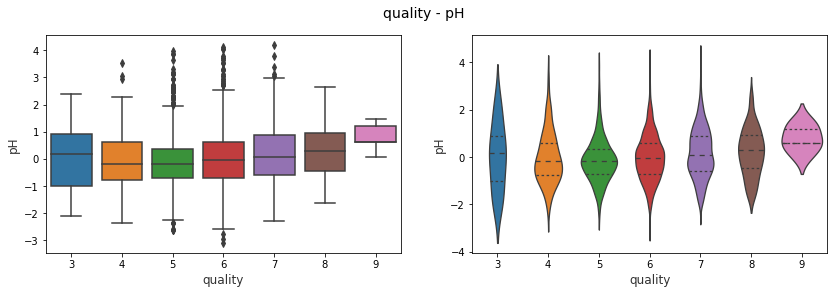

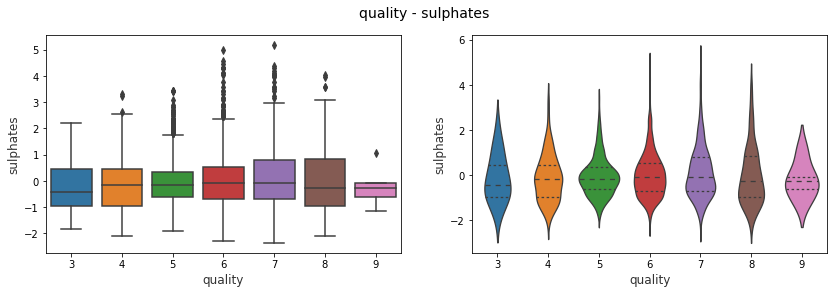

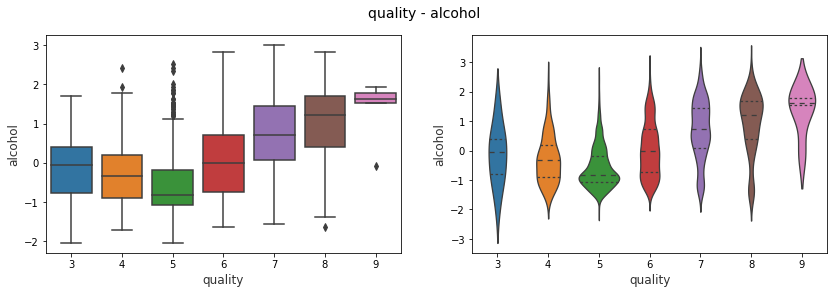

In [13]:
columns = inputDataScaled.columns.drop(['free_sulfur_dioxide', 'quality']) 
for i in range(columns.shape[0]): 
    BoxAndViolinPlot(columns[i], 'quality', inputDataScaled)

As it can be seen from the above figures, alcohol behavior differs depending on wine quality, whereas behavior of other variables are more or less similar. Small variations are also observed for pH, total_sulfur_dioxide, volatile_acidity and fixed_acidity. In addition, input data contains rather a lot of outliers.

# Quality Models

Let's try to build a model which predicts quality. First of all, let's define few support functions.

In [14]:
def gridSearch(algorithm, parameters, X_train, y_train):

    pipeline = Pipeline([('clf', algorithm)])
    gs = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
    fit = gs.fit(X_train, y_train)
    
    return fit

def printStatistics(gs, X_test, y_test):
    prediction = gs.predict(X_test)

    print('Accuracy  : {:.5f}'.format(gs.score(X_test, y_test)), sep = '\n')

    ##tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
    ##The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    print('Precision  : {:.5f}'.format(precision_score(y_test, prediction, average='micro')))
              
    ##tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
    ##The recall is intuitively the ability of the classifier to find all the positive samples.                     
    print('Recall  : {:.5f}'.format(recall_score(y_test, prediction, average='micro')))
                                
    ##F1 = 2 * (precision * recall) / (precision + recall)
    print('f1_score  : {:.5f}'.format(f1_score(y_test, prediction, average='micro')))
      
    print('Confusion matrix', confusion_matrix(y_test, prediction), sep = '\n')

    print('Best model parameters', gs.best_params_, sep = '\n')

In [15]:
X = inputDataScaled[['fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']] 
y = inputDataScaled.quality
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Decision Tree Classifier

In [16]:
decisionTreeClassifier_parameters =\
    [{ 'clf__class_weight': ['balanced', None], 
      'clf__criterion': ['gini', 'entropy'],
      'clf__splitter': ['best'],
      'clf__max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
      'clf__min_samples_leaf': [2, 3, 4, 5]
}]
decisionTreeClassifier_quality = gridSearch(DecisionTreeClassifier(random_state=1), decisionTreeClassifier_parameters, X_train, y_train)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [17]:
printStatistics(decisionTreeClassifier_quality, X_test, y_test)

Accuracy  : 0.58163
Precision  : 0.58163
Recall  : 0.58163
f1_score  : 0.58163
Confusion matrix
[[  0   1   0   1   0   0]
 [  0   6  12   6   5   0]
 [  6  13 183  82   6   3]
 [  2  12  98 271  49   3]
 [  0   3  20  54 100   7]
 [  0   1   4   7  15  10]]
Best model parameters
{'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples_leaf': 2, 'clf__splitter': 'best'}


Keeping in mind the results and exploratory data analysis, we can try to rebuild the model based on reduced data.

In [18]:
X_reduced = inputDataScaled[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',\
       'chlorides', 'total_sulfur_dioxide', 'pH', 'sulphates', 'alcohol']] 
y_reduced = inputDataScaled.quality
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = \
    train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=1)

In [19]:
decisionTreeClassifier_quality_reduced = gridSearch(DecisionTreeClassifier(random_state=1), \
                                                    decisionTreeClassifier_parameters, X_train_reduced, y_train_reduced)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [20]:
printStatistics(decisionTreeClassifier_quality_reduced, X_test_reduced, y_test_reduced)

Accuracy  : 0.59184
Precision  : 0.59184
Recall  : 0.59184
f1_score  : 0.59184
Confusion matrix
[[  0   1   0   1   0   0]
 [  0   6  11   9   3   0]
 [  1  17 185  78  11   1]
 [  1  12  91 283  44   4]
 [  0   2  18  63  96   5]
 [  0   0   5  12  10  10]]
Best model parameters
{'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__min_samples_leaf': 2, 'clf__splitter': 'best'}


Removing of density slightly increases model accurace. 

## Random Forest Classifier

Given that random forest classifier is rather time consuming, grid search was performed only once and "best parameters" (from considered set) was chosen.

In [21]:
randomForestClassifier_parameters =\
     [{
      'clf__class_weight': [None],
      'clf__criterion': ['entropy'],
      'clf__max_depth': [20],
      'clf__min_samples_leaf': [1],     
      'clf__min_samples_split': [2],
      'clf__n_estimators': [100]
     }]
         
randomForestClassifier_quality = gridSearch(RandomForestClassifier(random_state=1), randomForestClassifier_parameters, \
                                            X_train, y_train)

In [22]:
printStatistics(randomForestClassifier_quality, X_test, y_test)

Accuracy  : 0.67755
Precision  : 0.67755
Recall  : 0.67755
f1_score  : 0.67755
Confusion matrix
[[  0   0   1   1   0   0]
 [  0   5  13  10   1   0]
 [  0   0 187 104   2   0]
 [  0   0  54 351  30   0]
 [  0   0   3  71 107   3]
 [  0   0   0  11  12  14]]
Best model parameters
{'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


Let's try to use reduced data

In [23]:
randomForestClassifier_quality_reduced = gridSearch(RandomForestClassifier(random_state=1), randomForestClassifier_parameters, \
                       X_train_reduced, y_train_reduced)

In [24]:
printStatistics(randomForestClassifier_quality_reduced, X_test_reduced, y_test_reduced)

Accuracy  : 0.67551
Precision  : 0.67551
Recall  : 0.67551
f1_score  : 0.67551
Confusion matrix
[[  0   0   1   1   0   0]
 [  0   4  14  10   1   0]
 [  0   0 191 100   2   0]
 [  0   1  52 351  31   0]
 [  0   0   6  74 102   2]
 [  0   0   0  11  12  14]]
Best model parameters
{'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


As it can be seen, reduced data does not lead to any significant quality change.

## Gradient Boosting Classifier

Similarly to random forest, grid search was performed only once and "best parameters" (from considered set) was chosen.

In [25]:
gradientBoostingClassifier_parameters =\
    [{
      'clf__loss': ['deviance'],
      'clf__max_depth': [10],
      'clf__n_estimators': [200],
      'clf__min_samples_leaf': [3],     
      'clf__min_samples_split': [2],
     }]
         
gradientBoostingClassifier_quality = gridSearch(GradientBoostingClassifier(random_state=1), gradientBoostingClassifier_parameters, \
                                            X_train, y_train)

In [26]:
printStatistics(gradientBoostingClassifier_quality, X_test, y_test)

Accuracy  : 0.65714
Precision  : 0.65714
Recall  : 0.65714
f1_score  : 0.65714
Confusion matrix
[[  0   0   1   1   0   0]
 [  1   4  15   7   2   0]
 [  1   3 189  94   6   0]
 [  1   3  57 335  37   2]
 [  0   0   3  73 102   6]
 [  0   0   0  13  10  14]]
Best model parameters
{'clf__loss': 'deviance', 'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}


Let's try to use reduced data

In [27]:
gradientBoostingClassifier_quality_reduced = gridSearch(GradientBoostingClassifier(random_state=1), \
                                                        gradientBoostingClassifier_parameters, X_train_reduced, y_train_reduced)

In [28]:
printStatistics(gradientBoostingClassifier_quality_reduced, X_test_reduced, y_test_reduced)

Accuracy  : 0.66735
Precision  : 0.66735
Recall  : 0.66735
f1_score  : 0.66735
Confusion matrix
[[  0   0   1   1   0   0]
 [  1   5  13   8   2   0]
 [  0   5 190  95   3   0]
 [  0   2  59 337  36   1]
 [  0   0   9  62 108   5]
 [  0   0   1   9  13  14]]
Best model parameters
{'clf__loss': 'deviance', 'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}


Again, reduced data does not lead to any significant quality change.

## K-Neighbors Classifier

In [29]:
kNeighborsClassifier_parameters =\
    [{
      'clf__n_neighbors': [2, 5, 8, 12, 16, 20],
      'clf__weights': ['uniform', 'distance'],
      'clf__algorithm': ['ball_tree', 'kd_tree', 'brute'],
      'clf__leaf_size': [15, 30, 45],
      'clf__p': [1, 2, 3, 4] 
     }]
         
kNeighborsClassifier_quality = gridSearch(KNeighborsClassifier(), kNeighborsClassifier_parameters, \
                                            X_train, y_train)

In [30]:
printStatistics(kNeighborsClassifier_quality, X_test, y_test)

Accuracy  : 0.67959
Precision  : 0.67959
Recall  : 0.67959
f1_score  : 0.67959
Confusion matrix
[[  0   0   1   1   0   0]
 [  0   3  14  12   0   0]
 [  0   0 200  89   4   0]
 [  0   0  56 342  37   0]
 [  0   0   3  73 108   0]
 [  0   0   0  12  12  13]]
Best model parameters
{'clf__algorithm': 'ball_tree', 'clf__leaf_size': 15, 'clf__n_neighbors': 20, 'clf__p': 1, 'clf__weights': 'distance'}


In [31]:
kNeighborsClassifier_quality_reduced = gridSearch(KNeighborsClassifier(), kNeighborsClassifier_parameters, \
                                            X_train_reduced, y_train_reduced)

In [32]:
printStatistics(kNeighborsClassifier_quality_reduced, X_test_reduced, y_test_reduced)

Accuracy  : 0.68367
Precision  : 0.68367
Recall  : 0.68367
f1_score  : 0.68367
Confusion matrix
[[  0   0   1   1   0   0]
 [  0   3  14  12   0   0]
 [  0   0 192  96   5   0]
 [  0   0  50 354  31   0]
 [  0   0   6  68 108   2]
 [  0   0   0  14  10  13]]
Best model parameters
{'clf__algorithm': 'ball_tree', 'clf__leaf_size': 15, 'clf__n_neighbors': 16, 'clf__p': 1, 'clf__weights': 'distance'}


In general, the results are the same as for random forest and gradient boosting.

## Logistic Regression

In [33]:
logisticRegression_parameters =\
    [{
      'clf__C': [0.003, 0.009, 0.01],
      'clf__max_iter': [50, 100, 200],
      'clf__solver': ['newton-cg', 'sag', 'lbfgs'],
      'clf__penalty': ['l2', 'none'],
      'clf__tol' : [0.001, 0.0001, 0.00001],
      'clf__class_weight': [None, 'balanced']
     }]
         
logisticRegression_quality = gridSearch(LogisticRegression(random_state=1, multi_class = 'multinomial'),\
                                        logisticRegression_parameters, X_train, y_train)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


In [34]:
printStatistics(logisticRegression_quality, X_test, y_test)

Accuracy  : 0.50816
Precision  : 0.50816
Recall  : 0.50816
f1_score  : 0.50816
Confusion matrix
[[  0   0   1   1   0   0   0]
 [  0   1  17  10   1   0   0]
 [  0   0 143 149   1   0   0]
 [  0   0  87 316  31   0   1]
 [  0   0   5 141  38   0   0]
 [  0   0   0  27  10   0   0]
 [  0   0   0   0   0   0   0]]
Best model parameters
{'clf__C': 0.003, 'clf__class_weight': None, 'clf__max_iter': 50, 'clf__penalty': 'none', 'clf__solver': 'newton-cg', 'clf__tol': 0.001}


Given that results of logistic regression is considerable worse comparing with the above methods, it does not make sense to consider reduced data. The main reason for poor performance is that logistic regression assumes linear relationships between independent and dependent variables whereas during exploratory data analysis, it was clearly seen that relationships are not linear.

## Conclusions

According to the above analysis, the best performance is observed for the models which are based on random forest and k-neighbors algorithms. K-neighbors algorithm is so-called "lazy-learner" - it does not build the model itself but stores training data and calculates multiple distance for each prediction. Random forest is "eager learners" - it builds the model and make prediction faster than k-neighbors algorithm. So, let's chose random forest based model as final one.

# Quality Type Models

Let's try to split wine qulity by three types - "Low", "Medium" and "High"

In [35]:
quality_type = []
for i in inputDataScaled['quality']:
    if i >= 1 and i <= 4:
        quality_type.append(1)
    elif i >= 5 and i <= 6:
        quality_type.append(2)
    elif i >= 7 and i <= 10:
        quality_type.append(3)
          
inputDataScaled['quality_type'] = quality_type

In [36]:
ls = round(inputDataScaled[inputDataScaled['quality_type'] == 1][inputDataScaled.columns].describe(),2)
ms = round(inputDataScaled[inputDataScaled['quality_type'] == 2][inputDataScaled.columns].describe(),2)
hs = round(inputDataScaled[inputDataScaled['quality_type'] == 3][inputDataScaled.columns].describe(),2)
pd.concat([ls, ms, hs], axis=0, keys=['low quality', 'medium quality', 'high quality']).T

low quality                                             \
                           count  mean   std   min   25%   50%   75%    max   
fixed_acidity              183.0  0.39  1.39 -3.15 -0.54  0.05  0.94   5.86   
volatile_acidity           183.0  0.97  1.69 -1.67 -0.18  0.41  1.80   8.15   
citric_acid                183.0 -0.22  1.30 -2.76 -1.07 -0.28  0.54   4.51   
residual_sugar             183.0 -0.31  0.85 -1.12 -0.99 -0.73  0.22   2.20   
chlorides                  183.0  0.22  1.31 -1.50 -0.38  0.01  0.38  11.18   
free_sulfur_dioxide        183.0 -0.51  1.82 -1.90 -1.55 -1.02 -0.11  14.92   
total_sulfur_dioxide       183.0 -0.19  1.47 -3.02 -1.24 -0.46  0.91   7.10   
density                    183.0  0.11  0.84 -1.61 -0.48  0.02  0.66   2.13   
pH                         183.0 -0.03  1.12 -2.37 -0.85 -0.19  0.64   3.52   
sulphates                  183.0 -0.12  1.03 -2.10 -0.96 -0.17  0.44   3.33   
alcohol                    183.0 -0.28  0.84 -2.04 -0.91 -0.34  0.23   2.43   
quality                    183.0  3.89  0.31  3.00  4.00  4.00  4.00   4.00   
quality_type               183.0  1.00  0.00  1.00  1.00  1.00  1.00   1.00   

                     medium quality        ...              high quality  \
                              count  mean  ...   75%    max        count   
fixed_acidity                3655.0  0.03  ...  0.65   8.71       1060.0   
volatile_acidity             3655.0 -0.01  ...  0.41   6.81       1060.0   
citric_acid                  3655.0  0.03  ...  0.54  10.96       1060.0   
residual_sugar               3655.0  0.08  ...  0.81  11.71       1060.0   
chlorides                    3655.0  0.09  ...  0.24  13.74       1060.0   
free_sulfur_dioxide          3655.0  0.04  ...  0.69   5.63       1060.0   
total_sulfur_dioxide         3655.0  0.10  ...  0.82   4.84       1060.0   
density                      3655.0  0.15  ...  0.86  15.03       1060.0   
pH                           3655.0 -0.05  ...  0.48   4.12       1060.0   
sulphates                    3655.0 -0.02  ...  0.44   5.00       1060.0   
alcohol                      3655.0 -0.20  ...  0.39   2.83       1060.0   
quality                      3655.0  5.60  ...  6.00   6.00       1060.0   
quality_type                 3655.0  2.00  ...  2.00   2.00       1060.0   

                                                                
                      mean   std   min   25%   50%   75%   max  
fixed_acidity        -0.15  0.91 -3.50 -0.78 -0.18  0.41  2.78  
volatile_acidity     -0.13  0.93 -1.97 -0.88 -0.28  0.41  4.78  
citric_acid          -0.07  0.66 -2.68 -0.45 -0.20  0.21  3.35  
residual_sugar       -0.22  0.85 -1.10 -0.91 -0.50  0.20  2.54  
chlorides            -0.35  0.51 -1.55 -0.68 -0.40 -0.08  4.08  
free_sulfur_dioxide  -0.04  0.81 -1.78 -0.61 -0.14  0.39  4.27  
total_sulfur_dioxide -0.31  0.77 -2.46 -0.88 -0.39  0.18  2.13  
density              -0.54  0.93 -2.31 -1.18 -0.77 -0.14  2.20  
pH                    0.18  1.04 -2.31 -0.58  0.08  0.87  4.18  
sulphates             0.09  1.17 -2.36 -0.79 -0.09  0.79  5.17  
alcohol               0.73  1.02 -1.64  0.15  0.80  1.53  3.00  
quality               7.17  0.39  7.00  7.00  7.00  7.00  9.00  
quality_type          3.00  0.00  3.00  3.00  3.00  3.00  3.00  

[13 rows x 24 columns]

It can be seen that numerical characteristics are different between different quality types. Also, it should be mentioned that count of low quality is only 183 observations that may be too low for accurate model calibration. So, probably, it makes sense to consider different classification  for quality types. However, as we can see from the first histogram (at the top of notebook), most of observations are medium quality. It means that if we will shift borders for quality types, we will always get less observation in low or high quality type comparing with medium one.

Let's try to build aditional model based on quality types. First of all, let's define additional support function.

In [37]:
def plotRocCurves(gs, X_test, y_test):
    y_pred = gs.predict(X_test) 
    
    y_pred_low = [0 if x in [2, 3] else 1 for x in y_pred]
    y_test_low = [0 if x in [2, 3] else 1 for x in y_test]    
    
    y_pred_medium = [0 if x in [1, 3] else 1 for x in y_pred]
    y_test_medium = [0 if x in [1, 3] else 1 for x in y_test]
    
    y_pred_high = [0 if x in [1, 2] else 1 for x in y_pred]
    y_test_high = [0 if x in [1, 2] else 1 for x in y_test]
    
    plotRocCurve(y_test_low, y_pred_low, "low quality")
    plotRocCurve(y_test_medium, y_pred_medium, "medium quality")
    plotRocCurve(y_test_high, y_pred_high, "high quality")
    
def plotRocCurve(y_test, y_pred, quality_type):    
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title('ROC - ' + quality_type)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('true positive rate')
    plt.xlabel('false positive rate')
    plt.show()

Given the results of quality model calibration, let's continue with considering reduced data (without  'density') and only Random Forest and k-neighbors algorithms.

In [38]:
y_quality_Type = inputDataScaled.quality_type
X_train_reduced, X_test_reduced, y_train_qualityType_reduced, y_test_qualityType_reduced = \
    train_test_split(X_reduced, y_quality_Type, test_size=0.2, random_state=1)

## Random Forest Classifier

In [39]:
randomForestClassifier_parameters =\
     [{
      'clf__class_weight': [None],
      'clf__criterion': ['entropy'],
      'clf__max_depth': [20],
      'clf__min_samples_leaf': [1],     
      'clf__min_samples_split': [2],
      'clf__n_estimators': [100]
     }]
         
randomForestClassifier_qualityType_reduced = gridSearch(RandomForestClassifier(random_state=1), \
                                                        randomForestClassifier_parameters, \
                                                        X_train_reduced, y_train_qualityType_reduced)

In [40]:
printStatistics(randomForestClassifier_qualityType_reduced, X_test_reduced, y_test_qualityType_reduced)

Accuracy  : 0.85000
Precision  : 0.85000
Recall  : 0.85000
f1_score  : 0.85000
Confusion matrix
[[  3  27   1]
 [  1 693  34]
 [  0  84 137]]
Best model parameters
{'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


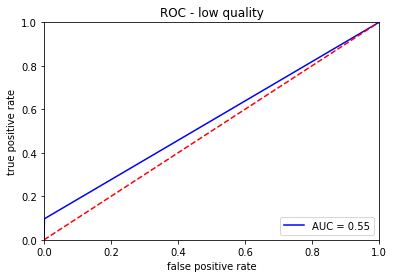

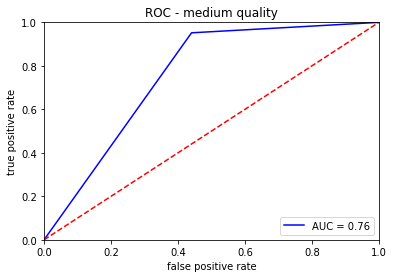

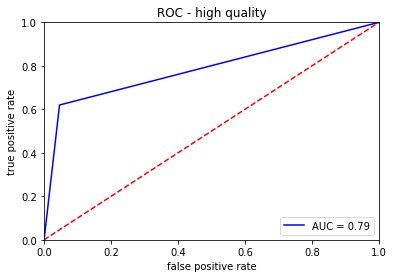

In [41]:
plotRocCurves(randomForestClassifier_qualityType_reduced, X_test_reduced, y_test_qualityType_reduced)

## K-Neighbors Classifier

In [42]:
kNeighborsClassifier_parameters =\
    [{
      'clf__n_neighbors': [20],
      'clf__weights': ['distance'],
      'clf__algorithm': ['ball_tree'],
      'clf__leaf_size': [15],
      'clf__p': [1] 
     }]
         
kNeighborsClassifier_qualityType_reduced = gridSearch(KNeighborsClassifier(), kNeighborsClassifier_parameters, \
                                            X_train_reduced, y_train_qualityType_reduced)

In [43]:
printStatistics(kNeighborsClassifier_qualityType_reduced, X_test_reduced, y_test_qualityType_reduced)

Accuracy  : 0.84898
Precision  : 0.84898
Recall  : 0.84898
f1_score  : 0.84898
Confusion matrix
[[  1  30   0]
 [  0 695  33]
 [  0  85 136]]
Best model parameters
{'clf__algorithm': 'ball_tree', 'clf__leaf_size': 15, 'clf__n_neighbors': 20, 'clf__p': 1, 'clf__weights': 'distance'}


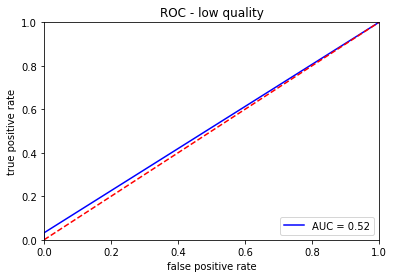

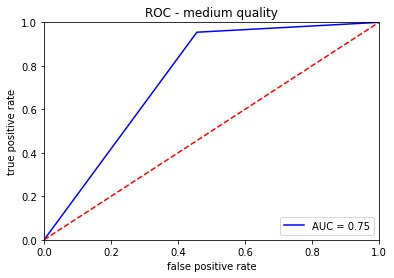

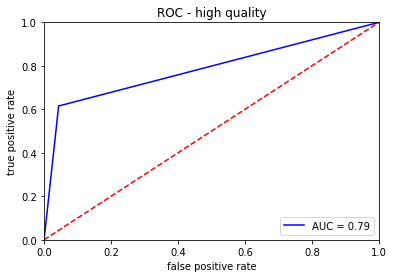

In [44]:
plotRocCurves(kNeighborsClassifier_qualityType_reduced, X_test_reduced, y_test_qualityType_reduced)

As it can be seen, the accuracy of both quality type models are much higher comparing with quality model that is expected given that more data for each quality type is available. Also, the accuracy of both random forest and k-neighbors is similar.

AUC score is rather high for medium and high quality, but is inappropriate for low quality, that is also expected given that we have only 183 observations for low quality.

Thus, taking into account the same thoughts as for quality model, the final model will based on random forest algorithm.

# Output

In [47]:
scalerFile = 'Calibrated Models/scaler.sav'
qualityModelFile = 'Calibrated Models/qualityModel.sav'
qualityTypeModeFile = 'Calibrated Models/qualityTypeModel.sav'

# generate scaler for reduced data in order we can scale original data while using calibrated models
scaler_reduced = StandardScaler()
dummy = inputData[inputData.columns.drop(['quality', 'density', 'free_sulfur_dioxide'])]
dummy = scaler_reduced.fit_transform(dummy)

joblib.dump(scaler_reduced, scalerFile)
joblib.dump(randomForestClassifier_quality_reduced, qualityModelFile)
joblib.dump(randomForestClassifier_qualityType_reduced, qualityTypeModeFile)

qualityModelTestData = X_test_reduced.copy()
qualityModelTestData['quality'] = y_test
qualityModelTestData.to_csv('Test Data/testData_qualityModel.csv')

qualityTypeModelTestData = X_test_reduced.copy()
qualityTypeModelTestData['qualityType'] = y_test_qualityType_reduced
qualityTypeModelTestData.to_csv('Test Data/testData_qualityTypeModel.csv')